This notebook provides an overview of developing and deploying ML applications using MLRun and GitHub. 

Tutorial steps:

1). Importing MLRun and creating a new project in MLRun
2). Configuring Git (user name, user email and create git remotes with a specific branch)
3). Developing and logging ML functions and artifacts -
    a. Register a dataset artifact in the project for data_fetch function
    b. Fetch Data func - register this function object into the project, run locally & remotely
    c. Train Model func - register this function object into the project, run locally & remotely
    d. Register a model artifact into the project
    e. Deployment - build, test, deploy and register model serving function
    f. Workflow - register a workflow (that will do steps c, e, f)
4). Pushing project context to Git (end of the day)
5). Pulling from Git to the project context(start of the day) and repeat from step 3 (if needed)
Note: any of the sub-steps in step 3 are optional. Working with Git can also apply on just one of these sub-steps.

In [1]:
import mlrun

In [2]:
# Make sure we have the same version of the scikit-learn on the client as in the server (not needed in MLRun 1.3 or higher)
! pip install scikit-learn==1.0.2


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Create a new project. The init_git flag is used to initialize git in the context dir (makes a hidden .git directory)
project = mlrun.new_project(name='new-git-project',init_git=True,overwrite=True)

> 2023-03-08 10:07:03,676 [info] Deleting project new-git-project from MLRun DB due to overwrite
> 2023-03-08 10:07:06,402 [info] Created and saved project new-git-project: {'from_template': None, 'overwrite': True, 'context': './', 'save': True}


In [4]:
# A Light project YAML looks like
print(project.to_yaml())

kind: project
metadata:
  name: new-git-project
spec:
  functions: []
  workflows: []
  artifacts: []
  source: git://github.com/GiladShapira94/test_push.git#refs/heads/master
  origin_url: git://github.com/GiladShapira94/test_push.git#refs/heads/master
  desired_state: online



If you are using containerized Jupyter you need to first set your Git parameters, using the following commands in MLRun CLI (The last command will not be needed at MLRun 1.3 as it will be part of the  .gitconfig file in the home directory)
```
git config --global user.email "<my@email.com>"
git config --global user.name "<name>"
git config --global credential.helper store
```

In [5]:
# # Run this only once (before remote origin already exists)
# project.create_remote("https://github.com/GiladShapira94/test_push.git")

In [6]:
# Register an artifact in the project, so that it can be further imported on project load  
from mlrun.artifacts import DatasetArtifact
data_url = 'https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv'
# Register an artifact in the project (to be used in workflows) 
project.set_artifact('data', artifact=DatasetArtifact(),target_path=data_url,tag='v1')    
project.register_artifacts() #saves the artifact in MLRun DB

In [7]:
data_art = project.get_artifact('data')

In [8]:
print(data_art.to_yaml())

kind: dataset
metadata:
  key: data
  project: new-git-project
  iter: 0
  tree: 7cf41317a2fafd12bf2d31b01860acb18ad4f8dc
  tag: latest
  updated: '2023-03-08T10:07:06.461378+00:00'
spec:
  target_path: https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv
  format: ''
  db_key: data
  producer:
    kind: project
    name: new-git-project
    tag: 7cf41317a2fafd12bf2d31b01860acb18ad4f8dc
  sources: []
  license: ''
status:
  state: created



In [9]:
# This is how the project YAML looks now
# print(project.to_yaml())

In [10]:
%%writefile fetch_data.py
import mlrun
@mlrun.handler(outputs=["dataset","label_column"])
def fetch_data(dataset):
    """
    A function which fetches data to MLRun
    """
    df = dataset.as_df()
    
    return df, "label"

Overwriting fetch_data.py


In [11]:
#Create a serverless function object from the code above, and register it in the project
fetch_data_fn = project.set_function("fetch_data.py", name="fetch_data", kind="job", image="mlrun/mlrun", handler="fetch_data")
project.save()  # save the project with the latest config

In [12]:
# This is how the project YAML looks now
# print(project.to_yaml())

In [13]:
# First run locally for debugging (Optional step)
# fetch_data_run_locally = project.run_function("fetch_data",inputs={'dataset':project.get_artifact('data').uri}, local=True)

In [14]:
# fetch_data_run_locally.artifact("dataset").as_df().head()

In [15]:
# Now run remotely 
fetch_data_run_remotely = project.run_function("fetch_data",inputs={'dataset':project.get_artifact('data').uri})

> 2023-03-08 10:07:06,887 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-03-08 10:07:06,904 [info] starting run fetch-data-fetch_data uid=1c2163cf2e6040c6b77ec491345f41d8 DB=http://mlrun-api:8080
> 2023-03-08 10:07:07,642 [info] Job is running in the background, pod: fetch-data-fetch-data-q77hx
> 2023-03-08 10:07:20,133 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 1c2163cf2e6040c6b77ec491345f41d8 -p new-git-project', 'logs_cmd': 'mlrun logs 1c2163cf2e6040c6b77ec491345f41d8 -p new-git-project'}
> 2023-03-08 10:07:20,134 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-git-project,...345f41d8,0,Mar 08 10:07:16,completed,fetch-data-fetch_data,kind=jobowner=jovyanmlrun/client_version=1.2.1-rc10host=fetch-data-fetch-data-q77hx,dataset,,label_column=label,dataset


> 2023-03-08 10:07:27,682 [info] run executed, status=completed


In [16]:
%%writefile trainer.py

import pandas as pd
import sklearn
from sklearn import ensemble
from sklearn.model_selection import train_test_split

import mlrun
from mlrun.frameworks.sklearn import apply_mlrun


@mlrun.handler()
def train(
    dataset: pd.DataFrame,
    label_column: str = "label",
    n_estimators: int = 100,
    learning_rate: float = 0.1,
    max_depth: int = 3,
    model_name: str = "iris_model",
):
    # Initialize the x & y data
    x = dataset.drop(label_column, axis=1)
    y = dataset[label_column]
    # print(sklearn.__version__)
    
    # Train/Test split the dataset
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    # Pick an ideal ML model
    model = ensemble.GradientBoostingClassifier(
        n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth
    )

    # -------------------- The only line you need to add for MLOps -------------------------
    # Wraps the model with MLOps (test set is provided for analysis & accuracy measurements)
    apply_mlrun(model=model, model_name=model_name, x_test=x_test, y_test=y_test)
    # --------------------------------------------------------------------------------------

    # Train the model
    model.fit(x_train, y_train)

Overwriting trainer.py


In [17]:
# The other option is to use the auto_trainer function form the hub:
# trainer = project.set_function(func="hub://auto_trainer")

In [18]:
#Create a serverless function object from the code above, and register it in the project
trainer = project.set_function(func="trainer.py", name="trainer", kind="job", image="mlrun/mlrun", handler="train")

In [19]:
#Run the function on the remote cluster (you can also run it locally at first by mentioning - local=True)
trainer_run = project.run_function("trainer",
        inputs={"dataset": fetch_data_run_remotely.outputs["dataset"]},
        params = {
            "model_class": "sklearn.ensemble.RandomForestClassifier",
            "train_test_split_size": 0.2,
            "label_columns": "label",
            "model_name":'iris_model'}, handler='train')

> 2023-03-08 10:07:27,756 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-03-08 10:07:28,144 [info] starting run trainer-train uid=598a24bb27194a41986d46a0276f4268 DB=http://mlrun-api:8080
> 2023-03-08 10:07:28,825 [info] Job is running in the background, pod: trainer-train-2pg4t
> 2023-03-08 10:07:41,037 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 598a24bb27194a41986d46a0276f4268 -p new-git-project', 'logs_cmd': 'mlrun logs 598a24bb27194a41986d46a0276f4268 -p new-git-project'}
> 2023-03-08 10:07:41,038 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-git-project,...276f4268,0,Mar 08 10:07:36,completed,trainer-train,kind=jobowner=jovyanmlrun/client_version=1.2.1-rc10host=trainer-train-2pg4t,dataset,model_class=sklearn.ensemble.RandomForestClassifiertrain_test_split_size=0.2label_columns=labelmodel_name=iris_model,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0,feature-importancetest_setconfusion-matrixroc-curvesmodel


> 2023-03-08 10:07:48,892 [info] run executed, status=completed


In [20]:
# Results (metrics) and artifacts are generated and tracked automatically by MLRun
# trainer_run.artifact('confusion-matrix').show()

In [21]:
# Register a model artifact in the project, so that it can be further imported on project load
from mlrun.artifacts import ModelArtifact
project.set_artifact('model', ModelArtifact(model_file="iris_model.pkl"), target_path='s3://mlrun/projects/new-git-proj/artifacts/trainer-train/0/model/')

In [22]:
#Create a model serving function
serving_fn = mlrun.new_function("serving", image="python:3.8", kind="serving", requirements=["mlrun[complete]", "scikit-learn==1.0.2"])


In [23]:
trainer_run.outputs

{'accuracy': 1.0,
 'f1_score': 1.0,
 'precision_score': 1.0,
 'recall_score': 1.0,
 'auc-micro': 1.0,
 'auc-macro': 1.0,
 'auc-weighted': 1.0,
 'feature-importance': 's3://mlrun/projects/new-git-project/artifacts/trainer-train/0/feature-importance.html',
 'test_set': 'store://artifacts/new-git-project/trainer-train_test_set:598a24bb27194a41986d46a0276f4268',
 'confusion-matrix': 's3://mlrun/projects/new-git-project/artifacts/trainer-train/0/confusion-matrix.html',
 'roc-curves': 's3://mlrun/projects/new-git-project/artifacts/trainer-train/0/roc-curves.html',
 'model': 'store://artifacts/new-git-project/iris_model:598a24bb27194a41986d46a0276f4268'}

In [24]:
#Add a model to the serving function
serving_fn.add_model('iris_model',model_path=trainer_run.outputs["model"], class_name='mlrun.frameworks.sklearn.SklearnModelServer')


In [25]:
# Simulating the model server locally
server = serving_fn.to_mock_server()

> 2023-03-08 10:07:48,974 [warning] run command, file or code were not specified
> 2023-03-08 10:07:50,176 [info] model iris_model was loaded
> 2023-03-08 10:07:50,177 [info] Loaded ['iris_model']


In [26]:
#Test the mock model server endpoint
# server.test("/v2/models/", method="GET")

In [27]:
# Infer using test data
my_data = {"inputs"
           :[[
               5,3,1.5,0.2]
            ]
}
server.test("/", body=my_data)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


{'id': 'ef988d1be03c45ce8828390810cfbc66',
 'model_name': 'iris_model',
 'outputs': ['Iris-setosa']}

Deploy a real-time serving function (over K8S or Docker). This requires Nuclio to be installed (over K8S or Docker).
Use the mlrun deploy_function() method to build and deploy a Nuclio serving function from your serving-function code
Use the mlrun deploy_function() method to build and deploy a Nuclio serving function from your serving-function code

In [28]:
project.deploy_function(serving_fn)

> 2023-03-08 10:07:50,210 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-03-08 10:07:50,212 [info] Starting remote function deploy
2023-03-08 10:07:50  (info) Deploying function
2023-03-08 10:07:50  (info) Building
2023-03-08 10:07:51  (info) Staging files and preparing base images
2023-03-08 10:07:51  (info) Building processor image
2023-03-08 10:09:17  (info) Build complete
2023-03-08 10:09:32  (info) Function deploy complete
> 2023-03-08 10:09:32,994 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-new-git-project-serving.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['192.168.224.227:31410']}


DeployStatus(state=ready, outputs={'endpoint': 'http://192.168.224.227:31410', 'name': 'new-git-project-serving'})

In [29]:
# Test the live endpoint
serving_fn.invoke("/", body=my_data)

> 2023-03-08 10:09:33,055 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-new-git-project-serving.mlrun.svc.cluster.local:8080/'}


{'id': 'af0aff20-cf5f-4d6f-86cd-c7df01c9ee0a',
 'model_name': 'iris_model',
 'outputs': ['Iris-setosa']}

In [30]:
# Before registering the serving function in the project (so that it can be further loaded from git) we first exporting
# its YAML, so that project YAML will look more compact (otherwise it will include the whole YAML of the serving function)
serving_fn.export('serving.yaml')
project.set_function(func='serving.yaml',name='serving',kind='serving')

> 2023-03-08 10:09:33,077 [info] function spec saved to path: serving.yaml


For setting a nuclio function you can see the example below:
```
project.set_function(func='nuclio.py',name='nuclio',handler='multi:multi_3',kind='nuclio',image='mlrun/mlrun')
Or
project.set_function(name='nuclio',handler='multi:multi_3',kind='nuclio',image='mlrun/mlrun',with_repo=True)
```

In [31]:
# Here is how the project YAML looks now
# print(project.to_yaml())

Build and run automated ML pipelines and CI/CD

A pipeline is created by running an MLRun “workflow”. The following code defines a workflow and 
writes it to a file in your local directory, with the file name workflow.py. The workflow describes
a directed acyclic graph (DAG) which is executed using the local, remote, or kubeflow engines.

See "running a multi-stage workflow". The defined pipeline includes the following steps:
Generate/prepare the data (fetch).
Train and the model (train).
Deploy the model as a real-time serverless function (serving).

In [32]:
%%writefile './workflow.py'

from kfp import dsl
import mlrun

# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(name="iris-git-demo")
def pipeline(dataset_uri,model_name="iris_model"):
    # Run the ingestion function with the new image and params
    ingest = mlrun.run_function(inputs={'dataset':dataset_uri},
        function="fetch_data",
        outputs=["dataset"], 
    )

    # Train a model using the trainer function
    train = mlrun.run_function(
        "trainer",
        inputs={"dataset": ingest.outputs["dataset"]},
        params = {
            "model_class": "sklearn.ensemble.RandomForestClassifier",
            "train_test_split_size": 0.2,
            "label_columns": "label",
            "model_name": model_name,
        }, 
        handler='train',
        outputs=["model"],
    )

    # Deploy the trained model as a serverless function
    mlrun.deploy_function(
        "serving",
        models=[
            {
                "key": model_name,
                "model_path": train.outputs["model"],
                "class_name": 'mlrun.frameworks.sklearn.SklearnModelServer',
            }
        ],
    )

Overwriting ./workflow.py


In [33]:
# Add a multi-stage workflow (./workflow.py) to the project with the name 'main' and save the project 
my_workflow = project.set_workflow('main', "./workflow.py")

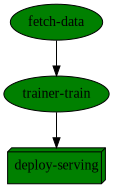

uid,start,state,name,parameters,results
...339b583a,Mar 08 10:10:41,completed,trainer-train,model_class=sklearn.ensemble.RandomForestClassifiertrain_test_split_size=0.2label_columns=labelmodel_name=iris_model,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0
...e5b9247a,Mar 08 10:09:56,completed,fetch-data,,label_column=label


In [34]:
# Run the workflow
run_id = project.run(
    #workflow_path="./workflow.py",
    name = 'main',
    arguments={'dataset_uri':project.get_artifact('data').uri}, 
    watch=True)

In [35]:
# Here is how project YAML looks now
print(project.to_yaml())

kind: project
metadata:
  name: new-git-project
spec:
  functions:
  - url: fetch_data.py
    name: fetch_data
    kind: job
    image: mlrun/mlrun
    handler: fetch_data
  - url: trainer.py
    name: trainer
    kind: job
    image: mlrun/mlrun
    handler: train
  - url: serving.yaml
    name: serving
    kind: serving
  workflows:
  - path: ./workflow.py
    name: main
  artifacts:
  - kind: dataset
    metadata:
      project: new-git-project
      tag: v1
      key: data
    spec:
      target_path: https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv
      format: ''
    status:
      state: created
  - kind: model
    metadata:
      project: new-git-project
      key: model
    spec:
      target_path: s3://mlrun/projects/new-git-proj/artifacts/trainer-train/0/model/
      model_file: iris_model.pkl
    status:
      state: created
  source: git://github.com/GiladShapira94/test_push.git#refs/heads/master
  origin_url: git://github.com/GiladShapira94/test_push.git#refs/

In [36]:
# # Pull the latest code from git (important if remote changed)
# project.pull("master")

In [37]:
# by default project.push pushes the project.yaml, so there is no need to include it in files_to_add
files_to_add = ['main.ipynb','fetch_data.py','serving.yaml','trainer.py','workflow.py','test.txt']
# Save the project state and commit/push updates to the remote git repo with all the files in files_to_add
project.push(branch='master',message='project with a workflow',add=files_to_add)

GitCommandError: Cmd('git') failed due to: exit code(128)
  cmdline: git push origin master
  stderr: 'remote: Permission to GiladShapira94/test_push.git denied to yevgenykhazan.
fatal: unable to access 'https://github.com/GiladShapira94/test_push.git/': The requested URL returned error: 403'

Congratulations! You've successfully pushed your poject to git

In [ ]:
# Is needed if the remote code changed after my push (e.g a team is working on the same branch)
project.pull("my_git_project") 

Congratulations! You've successfully pulled your poject from git